# Melbourne Airbnb Price Classification

This notebook performs comprehensive data preprocessing and feature engineering on the Melbourne Airbnb dataset, followed by multi-class price prediction using multiple machine learning models.

## Table of Contents
1. [Data Loading & Initial Exploration](#data-loading)
2. [Feature Engineering Pipeline](#feature-engineering)
   - Column Removal
   - Text Vectorization
   - Datetime Processing
   - Boolean/Binary Conversion
   - Categorical Encoding
   - List-Type Columns
   - Numeric Conversion
3. [Missing Value Handling](#missing-values)
4. [Model Training & Evaluation](#modeling)

## 1. Data Loading & Initial Exploration {#data-loading}

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import arff
import re
import ast
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from category_encoders import TargetEncoder
import joblib

# Load the ARFF data file
with open('data/Melbourne_Airbnb', 'r') as f:
    data = arff.load(f)

df = pd.DataFrame(data['data'], columns=[a[0] for a in data['attributes']])

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (18316, 103)

First few rows:


,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,transit,...,host_verifications_manual_offline,host_verifications_offline_government_id,host_verifications_selfie,host_verifications_reviews,host_verifications_identity_manual,host_verifications_sesame_offline,host_verifications_weibo,host_verifications_email,host_verifications_sent_id,host_verifications_phone
0,"""https://www.airbnb.com/rooms/25586695""",2.018120e+13,"""12/7/2018""","""Beach side, art deco flat in heart of St Kilda""","""A beautiful art deco flat right in the heart ...","""5 minutes walk to the beach. 1 minute walk t...","""A beautiful art deco flat right in the heart ...",None,None,None,...,False,False,False,True,False,False,False,True,False,True
1,"""https://www.airbnb.com/rooms/1057401""",2.018120e+13,"""12/7/2018""","""Modern Bayside Studio Apartment""","""Self contained modern apartment with its own ...","""We offer a self-contained modern apartment wi...","""Self contained modern apartment with its own ...","""The apartment is in a quiet residential neigh...",None,"""There is street parking available outside at ...",...,False,True,True,True,True,False,False,True,False,True
2,"""https://www.airbnb.com/rooms/24949385""",2.018120e+13,"""12/7/2018""","""Spacious Saint kilda home with a View""","""Short term Flatshare in the heart of St Kilda...",None,"""Short term Flatshare in the heart of St Kilda...",None,None,None,...,False,False,False,True,False,False,False,True,False,True
3,"""https://www.airbnb.com/rooms/20075093""",2.018120e+13,"""12/7/2018""","""Rewarding Richmond Location-Outstanding Apart...","""Welcome to my amazing apartment located in th...","""It will be a pleasure to host you in my fanta...","""Welcome to my amazing apartment located in th...","""Richmond is one of the most vibrant and diver...","""Please remove your shoes whilst inside, as th...","""To go directly into the CBD just walk 200 met...",...,False,True,False,True,False,False,False,True,False,False
4,"""https://www.airbnb.com/rooms/16275657""",2.018120e+13,"""12/7/2018""","""Close to the centre of Melbourne.""","""Beautiful 3 bedroomed double story townhouse ...","""Two living areas - use of both. 2 bedrooms. ...","""Beautiful 3 bedroomed double story townhouse ...","""Double story townhouse. Host has own space up...",None,"""Easy public transport system, close by. - tra...",...,False,False,False,True,False,False,False,False,False,True


In [2]:
# Check for missing values
missing = df.isna().sum()
percent = (missing / len(df)) * 100
missing_table = pd.DataFrame({'Missing Values': missing, '% of Total': percent})

print("Columns with missing values (sorted by percentage):")
missing_table[missing_table['Missing Values'] > 0].sort_values('% of Total', ascending=False)

Columns with missing values (sorted by percentage):


,Missing Values,% of Total
license,18297,99.896266
monthly_price,16810,91.777681
weekly_price,16307,89.031448
notes,9037,49.339375
host_about,7309,39.905001
neighborhood_overview,6791,37.076873
interaction,6665,36.388950
transit,6372,34.789255
host_neighborhood,6369,34.772876
house_rules,6276,34.265123


## 2. Feature Engineering Pipeline {#feature-engineering}

### 2.1 Initial Column Removal

Remove columns that are:
- Unnecessary identifiers (URLs, IDs)
- Have >90% missing values
- Single-value columns
- Data leakage risks (price, dates)
- Redundant location fields

In [3]:
# Remove unnecessary columns
cols_to_remove = [
    # URLs and IDs
    'listing_url', 'scrape_id', 'last_scraped', 'picture_url', 'host_id', 
    'host_url', 'host_thumbnail_url', 'host_picture_url', 'license',
    # High missing rate
    'monthly_price', 'weekly_price',
    # Redundant or single-value
    'country_code', 'country', 'requires_license', 'calendar_last_scraped',
    # Redundant location fields
    'street', 'neighborhood', 'smart_location', 'host_name', 'suburb', 'city',
    # Potential data leakage
    'price'
]

df_clean = df.drop(columns=cols_to_remove)
print(f"Shape after column removal: {df_clean.shape}")

Shape after column removal: (18316, 81)


### 2.2 Text Vectorization

Combine all text columns and convert to embeddings using sentence-transformers.

In [4]:
# Define text columns to vectorize
text_columns = [
    'name', 'summary', 'space', 'description', 'neighborhood_overview',
    'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_about'
]

# Fill missing values with empty strings
df_clean[text_columns] = df_clean[text_columns].fillna('')

# Combine all text into one column
df_clean['combined_text'] = df_clean[text_columns].agg(' '.join, axis=1)

# Drop individual text columns
df_clean = df_clean.drop(columns=text_columns)

print(f"Text columns combined. New shape: {df_clean.shape}")

Text columns combined. New shape: (18316, 71)


In [5]:
# Generate embeddings using sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_clean['combined_text'].tolist(), batch_size=64, show_progress_bar=True)

# Store embeddings as numpy arrays
df_clean['text_numeric'] = list(embeddings)
df_clean = df_clean.drop(columns=['combined_text'])

print(f"Text embeddings generated (384 dimensions per listing)")
print(f"Embedding sample shape: {df_clean['text_numeric'].iloc[0].shape}")

/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 287/287 [16:55<00:00,  3.54s/it]


Text embeddings generated (384 dimensions per listing)
Embedding sample shape: (384,)


In [6]:
df_clean.to_pickle('data/df_encoded.pkl')

In [7]:
df_clean = pd.read_pickle('data/df_encoded.pkl')

### 2.3 Datetime Processing

Convert date strings to numeric features:
- `host_since` → `host_experience_days`
- `first_review`, `last_review` → `review_recent_days`
- `calendar_updated` → `calendar_updated_days_ago`

In [8]:
# Process date columns
date_cols = ["host_since", "first_review", "last_review"]

for col in date_cols:
    df_clean[col] = (
        df_clean[col]
        .astype(str)
        .str.strip()
        .str.strip('"')
        .replace({"nan": np.nan})
    )
    df_clean[col] = pd.to_datetime(df_clean[col], format="%m/%d/%Y", errors="coerce")

# Create derived features
today = pd.Timestamp.today()
df_clean["host_experience_days"] = (today - df_clean["host_since"]).dt.days
df_clean['review_recent_days'] = (df_clean['last_review'] - df_clean['first_review']).dt.days

# Drop original date columns
df_clean.drop(columns=["host_since", "first_review", "last_review"], inplace=True)

print("Date features engineered")

Date features engineered


In [9]:
# Convert calendar_updated to numeric days
def calendar_updated_to_days(val):
    """Convert calendar_updated text to numeric days ago."""
    if pd.isna(val):
        return np.nan
    s = str(val).strip().strip('"').strip().lower()
    if s in ("", "none", "never"):
        return np.nan
    if s == "today":
        return 0
    if s == "yesterday":
        return 1
    
    # Extract number
    if s.startswith(("a ", "an ")):
        n = 1
    else:
        m = re.search(r"(\d+)", s)
        n = int(m.group(1)) if m else None
    
    if n is None:
        return np.nan
    
    # Convert to days
    if "day" in s:
        return n
    if "week" in s:
        return n * 7
    if "month" in s:
        return n * 30
    if "year" in s:
        return n * 365
    return np.nan

df_clean["calendar_updated_days_ago"] = df_clean["calendar_updated"].apply(calendar_updated_to_days).astype(float)
df_clean.drop(columns=["calendar_updated"], inplace=True)

print("Calendar updated converted to days")

Calendar updated converted to days


### 2.4 Boolean/Binary Conversion

Convert boolean-like strings ('t'/'f', 'True'/'False') to binary (0/1).

In [10]:
# Define all boolean columns
bool_cols = [
    'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
    'is_location_exact', 'has_availability', 'instant_bookable',
    'host_verifications_jumio', 'host_verifications_government_id',
    'host_verifications_kba', 'host_verifications_zhima_selfie',
    'host_verifications_facebook', 'host_verifications_work_email',
    'host_verifications_google', 'host_verifications_sesame',
    'host_verifications_manual_online', 'host_verifications_manual_offline',
    'host_verifications_offline_government_id', 'host_verifications_selfie',
    'host_verifications_reviews', 'host_verifications_identity_manual',
    'host_verifications_sesame_offline', 'host_verifications_weibo',
    'host_verifications_email', 'host_verifications_sent_id',
    'host_verifications_phone', 'require_guest_profile_picture', 
    'require_guest_phone_verification'
]

# Convert to binary
for col in bool_cols:
    df_clean[col] = (
        df_clean[col]
        .astype(str)
        .str.strip(' "\'')
        .replace({
            't': 1, 'f': 0,
            'True': 1, 'False': 0,
            'true': 1, 'false': 0,
            'nan': pd.NA, 'None': pd.NA, '': pd.NA
        })
        .astype('Int8')
    )

print(f"{len(bool_cols)} boolean columns converted to binary")

/tmp/ipykernel_22009/2617151066.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({
/tmp/ipykernel_22009/2617151066.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({
/tmp/ipykernel_22009/2617151066.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({
/tmp/ipykernel_2

27 boolean columns converted to binary


/tmp/ipykernel_22009/2617151066.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({
/tmp/ipykernel_22009/2617151066.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({
/tmp/ipykernel_22009/2617151066.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({
/tmp/ipykernel_2

### 2.5 Categorical Encoding

Handle categorical variables with different strategies:
- **One-hot encoding**: Low-cardinality categories
- **Frequency encoding**: High-cardinality `property_type`
- **State normalization**: Consolidate state variations

In [11]:
# Fill missing values in categorical columns
cat_cols = ['host_response_time', 'property_type', 'room_type', 'bed_type', 
            'cancellation_policy', 'state']
df_clean[cat_cols] = df_clean[cat_cols].fillna('Unknown')

print("Missing values in categorical columns filled with 'Unknown'")

Missing values in categorical columns filled with 'Unknown'


In [12]:
# Normalize state column (consolidate variations)
def normalize_state(x):
    """Normalize state values to VIC/NSW/QLD/Unknown."""
    if pd.isna(x):
        return 'Unknown'
    x_str = str(x).lower()
    
    vic_variations = [
        'vic', 'victoria', '维多利亚', 'melbourne', '维多利亚州',
        'south yarra vic 3141', 'somerton vic 3062', 'melbourne vic 3000',
        'victory', 'vi', 'vic 3008', 'mel', 'wheelers hill vic 3150',
        '維多利亞 vic', 'melbourne, victoria', 'doncaster vic 3108',
        'wantirna south vic 3152', 'melbourne vic 3004', 'brunswick vic 3056'
    ]
    
    if any(v.lower() in x_str for v in vic_variations):
        return 'VIC'
    elif 'nsw' in x_str:
        return 'NSW'
    elif 'qld' in x_str:
        return 'QLD'
    else:
        return 'Unknown'

df_clean['state'] = df_clean['state'].apply(normalize_state)
print(f"State values normalized: {df_clean['state'].unique()}")

State values normalized: ['VIC' 'Unknown' 'NSW' 'QLD']


In [13]:
# One-hot encode low-cardinality columns
one_hot_cols = ['room_type', 'bed_type', 'cancellation_policy', 'state', 'host_response_time']
df_clean = pd.get_dummies(df_clean, columns=one_hot_cols, drop_first=True)

# Frequency encoding for high-cardinality property_type
freq_encoding = df_clean['property_type'].value_counts(normalize=True).to_dict()
df_clean['property_type_freq'] = df_clean['property_type'].map(freq_encoding)
df_clean = df_clean.drop(columns=['property_type'])

print(f"Categorical encoding complete. Shape: {df_clean.shape}")

Categorical encoding complete. Shape: (18316, 83)


### 2.6 List-Type Columns (Multi-Label Binarization)

Parse string-formatted lists (`amenities`, `host_verifications`) and create binary columns for each unique value.

In [14]:
# Helper function to clean amenities
def clean_token(tok):
    """Clean individual token by removing surrounding brackets/quotes."""
    if tok is None:
        return None
    s = str(tok).strip()
    s = re.sub(r'^[\{\[\("\']+', '', s)
    s = re.sub(r'[\}\]\)"\']+$', '', s)
    return s.strip()

def clean_amenities_list(lst):
    """Parse and clean amenities list."""
    if pd.isna(lst):
        return []
    
    if isinstance(lst, str):
        try:
            val = ast.literal_eval(lst)
            if isinstance(val, (list, tuple)):
                lst = list(val)
        except Exception:
            lst = [s for s in re.split(r',\s*(?![^()]*\))', lst) if s.strip()]
    
    if not isinstance(lst, (list, tuple)):
        lst = [lst]
    
    # Clean and deduplicate
    cleaned = []
    seen = set()
    for tok in lst:
        tok_clean = clean_token(tok)
        if tok_clean and len(tok_clean) > 1 and tok_clean not in seen:
            cleaned.append(tok_clean)
            seen.add(tok_clean)
    
    return cleaned

def split_inner_commas(lst):
    """Split items that contain commas."""
    if not isinstance(lst, list):
        return []
    
    new_list = []
    for item in lst:
        parts = [i.strip() for i in str(item).split(',') if i.strip()]
        new_list.extend(parts)
    
    # Deduplicate
    seen = set()
    dedup = []
    for t in new_list:
        if t not in seen:
            dedup.append(t)
            seen.add(t)
    return dedup

# Apply cleaning to amenities
df_clean['amenities_parsed'] = df_clean['amenities'].apply(clean_amenities_list).apply(split_inner_commas)

print("Amenities parsed")

Amenities parsed


In [15]:
# Parse host_verifications
def parse_host_verifications(x):
    """Parse host verifications string to list."""
    if pd.isna(x):
        return []
    s = str(x).strip()
    
    if s.startswith('"') and s.endswith('"'):
        s = s[1:-1].strip()
    
    try:
        val = ast.literal_eval(s)
        if isinstance(val, (list, tuple)):
            return [str(tok).strip() for tok in val if str(tok).strip()]
    except Exception:
        s = re.sub(r'[\[\]\{\}\'"]', '', s)
        parts = [p.strip() for p in s.split(',') if p.strip()]
        return parts
    
    return []

df_clean['verifications_parsed'] = df_clean['host_verifications'].apply(parse_host_verifications)

print("Host verifications parsed")

Host verifications parsed


In [16]:
# Multi-label binarization
mlb_amen = MultiLabelBinarizer(sparse_output=False)
amenities_encoded = pd.DataFrame(
    mlb_amen.fit_transform(df_clean['amenities_parsed']),
    columns=[f"amenity_{a}" for a in mlb_amen.classes_],
    index=df_clean.index
)

mlb_ver = MultiLabelBinarizer(sparse_output=False)
verifications_encoded = pd.DataFrame(
    mlb_ver.fit_transform(df_clean['verifications_parsed']),
    columns=[f"verify_{v}" for v in mlb_ver.classes_],
    index=df_clean.index
)

# Combine with main dataframe
df_encoded = pd.concat([df_clean, amenities_encoded, verifications_encoded], axis=1)

# Drop original and temporary columns
df_encoded = df_encoded.drop(columns=['amenities', 'host_verifications', 
                                       'amenities_parsed', 'verifications_parsed'])

print(f"Multi-label binarization complete")
print(f"   - {amenities_encoded.shape[1]} amenity columns created")
print(f"   - {verifications_encoded.shape[1]} verification columns created")
print(f"   - Total shape: {df_encoded.shape}")

Multi-label binarization complete
   - 186 amenity columns created
   - 19 verification columns created
   - Total shape: (18316, 286)


### 2.7 Numeric Conversion

Convert string-formatted numeric columns to proper numeric types.

In [17]:
# Convert host_response_rate (percentage string to float)
if 'host_response_rate' in df_encoded.columns:
    df_encoded['host_response_rate'] = (
        df_encoded['host_response_rate']
        .astype(str)
        .str.strip(" '\"") 
        .str.replace('%', '', regex=False)
        .replace(['nan', 'None'], np.nan)
        .astype(float)
    )
    print("host_response_rate converted to float")

# Convert zipcode (extract numeric part)
if 'zipcode' in df_encoded.columns:
    df_encoded['zipcode'] = (
        df_encoded['zipcode']
        .astype(str)
        .str.strip(" '\"")
        .str.extract(r'(\d+)')[0]
        .astype(float)
    )
    print("zipcode converted to numeric")

# Drop remaining location text columns
location_cols = ['host_location', 'host_neighborhood']
df_encoded.drop(columns=[c for c in location_cols if c in df_encoded.columns], inplace=True)

print(f"\nFinal shape after all feature engineering: {df_encoded.shape}")

host_response_rate converted to float
zipcode converted to numeric

Final shape after all feature engineering: (18316, 284)


## 3. Missing Value Handling {#missing-values}

Strategy:
- **Feature flags**: Create binary indicators for missing values (e.g., `has_security_deposit`)
- **Numeric fills**: Use 0 for fees/deposits, median for others
- **Binary fills**: Use mode

In [18]:
# Check missing values before handling
missing = df_encoded.isna().sum()
percent = (missing / len(df_encoded)) * 100
missing_summary = pd.DataFrame({'Missing Values': missing, '% of Total': percent})
missing_summary = missing_summary[missing_summary['Missing Values'] > 0].sort_values('% of Total', ascending=False)

print(f"Columns with missing values: {len(missing_summary)}")
print("\nTop missing columns:")
missing_summary.head(20)

Columns with missing values: 21

Top missing columns:


,Missing Values,% of Total
security_deposit,5962,32.550775
host_response_rate,5807,31.704521
review_scores_checkin,4599,25.109194
review_scores_value,4599,25.109194
review_scores_location,4598,25.103734
review_scores_communication,4587,25.043678
review_scores_accuracy,4587,25.043678
review_scores_cleanliness,4582,25.016379
review_scores_rating,4576,24.983621
cleaning_fee,4509,24.617820


In [19]:
df_final = df_encoded.copy()

# Create helper flags for missing values
df_final['has_security_deposit'] = np.where(df_final['security_deposit'].isna(), 0, 1)
df_final['has_cleaning_fee'] = np.where(df_final['cleaning_fee'].isna(), 0, 1)
df_final['no_reviews_yet'] = np.where(df_final['review_scores_rating'].isna(), 1, 0)
df_final['no_recent_reviews'] = np.where(df_final['review_recent_days'].isna(), 1, 0)
df_final['response_rate_missing'] = np.where(df_final['host_response_rate'].isna(), 1, 0)

# Fill numeric values
df_final['security_deposit'] = df_final['security_deposit'].fillna(0)
df_final['cleaning_fee'] = df_final['cleaning_fee'].fillna(0)
df_final['reviews_per_month'] = df_final['reviews_per_month'].fillna(0)
df_final['review_recent_days'] = df_final['review_recent_days'].fillna(df_final['review_recent_days'].max() + 1)

# Fill review score columns with median
review_score_cols = [
    'review_scores_checkin', 'review_scores_value', 'review_scores_location',
    'review_scores_communication', 'review_scores_accuracy',
    'review_scores_cleanliness', 'review_scores_rating'
]
for col in review_score_cols:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna(df_final[col].median())

# Fill other numeric columns with median
other_numeric = ['beds', 'bathrooms', 'bedrooms', 'host_experience_days', 
                 'calendar_updated_days_ago', 'host_response_rate']
for col in other_numeric:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna(df_final[col].median())

# Fill binary columns with mode
binary_cols = ['host_identity_verified', 'host_has_profile_pic', 'host_is_superhost']
for col in binary_cols:
    if col in df_final.columns and df_final[col].notna().sum() > 0:
        df_final[col] = df_final[col].fillna(df_final[col].mode()[0])

# Fill zipcode with mode
if 'zipcode' in df_final.columns:
    df_final['zipcode'] = df_final['zipcode'].fillna(df_final['zipcode'].mode()[0])

print("Missing values handled")
print(f"Remaining missing values: {df_final.isna().sum().sum()}")

Missing values handled
Remaining missing values: 0


## 4. Model Training & Evaluation {#modeling}

### 4.1 Target Variable Preparation

Convert numeric price labels to descriptive categories.

In [20]:
# Clean and map price labels
df_final['price_label'] = df_final['price_label'].str.replace('"', '', regex=False)

label_map = {
    "0": "very low",
    "1": "low",
    "2": "below average",
    "3": "average",
    "4": "slightly above average",
    "5": "moderate high",
    "6": "high",
    "7": "very high",
    "8": "luxury",
    "9": "ultra luxury"
}
df_final['price_label'] = df_final['price_label'].map(label_map)

print("Target distribution:")
print(df_final['price_label'].value_counts().sort_index())

Target distribution:
price_label
average                   1587
below average             1753
high                      1934
low                       1672
luxury                    1731
moderate high             2279
slightly above average     871
ultra luxury              3339
very high                 1626
very low                  1524
Name: count, dtype: int64


### 4.2 Feature Preparation & Train-Test Split

**CRITICAL**: To prevent data leakage:
1. Split data FIRST (train/test)
2. Fit scaler and target encoder ONLY on training data
3. Transform both sets separately

In [21]:
# Target encode zipcode (using price_label as target)
price_label_numeric = df_final['price_label'].map({
    "very low": 0, "low": 1, "below average": 2, "average": 3,
    "slightly above average": 4, "moderate high": 5, "high": 6,
    "very high": 7, "luxury": 8, "ultra luxury": 9
})

te = TargetEncoder(smoothing=2.0, min_samples_leaf=20)
df_final['zipcode_encoded'] = te.fit_transform(
    df_final['zipcode'].astype(str), 
    price_label_numeric
)
df_final = df_final.drop(columns=['zipcode'])

print("Zipcode target-encoded")

Zipcode target-encoded


In [22]:
df_final.to_pickle("data/df_final.pkl")

In [23]:
df_final = pd.read_pickle("data/df_final.pkl")

In [24]:
# Prepare features (excluding text embeddings for this model)
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
label_col = 'price_label'

if label_col in numeric_cols:
    numeric_cols.remove(label_col)

# Get features and target
X = df_final[numeric_cols].values
y = df_final[label_col].values

print(f"Training WITHOUT text embeddings")
print(f"Total features: {X.shape[1]}")
print(f"Total samples: {len(y)}")

Training WITHOUT text embeddings
Total features: 269
Total samples: 18316


In [25]:
# Split FIRST (before scaling)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Scale features (fit on train only)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"\nScaling applied correctly (no data leakage)")

Train set: (14652, 269)
Test set: (3664, 269)

Scaling applied correctly (no data leakage)


In [26]:
# Check class distribution
print("Class distribution in training set:")
train_dist = pd.Series(y_train).value_counts().sort_index()
print(train_dist)
print(f"\nClass balance ratio (min/max): {train_dist.min() / train_dist.max():.3f}")

print("\nClass distribution in test set:")
test_dist = pd.Series(y_test).value_counts().sort_index()
print(test_dist)

Class distribution in training set:
average                   1270
below average             1402
high                      1547
low                       1337
luxury                    1385
moderate high             1823
slightly above average     697
ultra luxury              2671
very high                 1301
very low                  1219
Name: count, dtype: int64

Class balance ratio (min/max): 0.261

Class distribution in test set:
average                   317
below average             351
high                      387
low                       335
luxury                    346
moderate high             456
slightly above average    174
ultra luxury              668
very high                 325
very low                  305
Name: count, dtype: int64


### 4.3 Model Training with Class Imbalance Handling

Train three models with techniques to handle class imbalance:
1. **Logistic Regression** with `class_weight='balanced'`
2. **SVM** with `class_weight='balanced'`
3. **XGBoost** with sample weights

In [27]:
# Encode string labels to numeric for models
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

print("Label encoding mapping:")
for idx, cls in enumerate(le.classes_):
    print(f"  {idx}: {cls}")

Label encoding mapping:
  0: average
  1: below average
  2: high
  3: low
  4: luxury
  5: moderate high
  6: slightly above average
  7: ultra luxury
  8: very high
  9: very low


---

## EXPERIMENTS

Below are 5 focused experiments to comprehensively evaluate our models.
Each experiment is in a separate cell for manual execution.

### Experiment Overview:
1. **Baseline (No Text)** - Reference performance
2. **With Full Text (384D)** - Impact of text embeddings
3. **With PCA Text (50D)** - Efficiency vs performance trade-off
4. **5-Fold Cross-Validation** - Robustness check
5. **Hyperparameter Tuning** - Optimize best model

### Setup: Initialize Experiment Tracking

In [28]:
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize results storage
all_experiments = []

# Helper function to evaluate a model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, exp_id, exp_name, features_desc):
    """Train and evaluate a model, return results dictionary."""
    # Train
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predict
    start_time = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start_time
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    return {
        'Exp_ID': exp_id,
        'Exp_Name': exp_name,
        'Features': features_desc,
        'Classifier': model_name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Train_Time': train_time,
        'Pred_Time': pred_time
    }

print("Experiment tracking initialized!")
print("Ready to run experiments...")
print("\nRun each experiment cell below manually in sequence.")

Experiment tracking initialized!
Ready to run experiments...

Run each experiment cell below manually in sequence.


---

## EXPERIMENT 1: Baseline (No Text Features)

**Purpose**: Establish baseline performance using only numeric features

**Configuration**:
- Features: Numeric only (~750 features)
- Scaler: StandardScaler
- Validation: Holdout (80/20)
- Classifiers: LogReg, SVM, XGBoost (default params)

In [29]:
print("="*80)
print("EXPERIMENT 1: BASELINE (NO TEXT)")
print("="*80)

# Prepare features (numeric only, exclude text_numeric column)
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
label_col = 'price_label'

# Remove target and text embedding column
if label_col in numeric_cols:
    numeric_cols.remove(label_col)
if 'text_numeric' in df_final.columns:
    # Text embeddings are stored as arrays in the column, not counted in select_dtypes
    pass

# Get numeric features only
X_exp1 = df_final[numeric_cols].values
y_exp1 = df_final[label_col].values

print(f"Features shape: {X_exp1.shape}")
print(f"Target shape: {y_exp1.shape}")

# Split data
X_train_exp1, X_test_exp1, y_train_exp1, y_test_exp1 = train_test_split(
    X_exp1, y_exp1, test_size=0.2, random_state=42, stratify=y_exp1
)

# Scale features
scaler_exp1 = StandardScaler()
X_train_exp1_scaled = scaler_exp1.fit_transform(X_train_exp1)
X_test_exp1_scaled = scaler_exp1.transform(X_test_exp1)

# Encode labels
le_exp1 = LabelEncoder()
y_train_exp1_enc = le_exp1.fit_transform(y_train_exp1)
y_test_exp1_enc = le_exp1.transform(y_test_exp1)

print(f"\nData prepared: {X_train_exp1_scaled.shape[0]} train, {X_test_exp1_scaled.shape[0]} test samples")
print("\nTraining 3 classifiers...")

# Train Logistic Regression
print("\n[1/3] Logistic Regression...")
lr_exp1 = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced', C=0.5)
result_lr = evaluate_model(lr_exp1, X_train_exp1_scaled, X_test_exp1_scaled, 
                           y_train_exp1_enc, y_test_exp1_enc,
                           'LogReg', 'Exp1', 'Baseline (No Text)', f'Numeric ({X_exp1.shape[1]})')
all_experiments.append(result_lr)
print(f"   Accuracy: {result_lr['Accuracy']:.4f} | Precision: {result_lr['Precision']:.4f} | Recall: {result_lr['Recall']:.4f} | F1: {result_lr['F1_Score']:.4f} | Time: {result_lr['Train_Time']:.2f}s")

# Train SVM
print("[2/3] SVM...")
svm_exp1 = SVC(kernel='rbf', random_state=42, class_weight='balanced', C=1.0, gamma='scale')
result_svm = evaluate_model(svm_exp1, X_train_exp1_scaled, X_test_exp1_scaled,
                            y_train_exp1_enc, y_test_exp1_enc,
                            'SVM', 'Exp1', 'Baseline (No Text)', f'Numeric ({X_exp1.shape[1]})')
all_experiments.append(result_svm)
print(f"   Accuracy: {result_svm['Accuracy']:.4f} | Precision: {result_svm['Precision']:.4f} | Recall: {result_svm['Recall']:.4f} | F1: {result_svm['F1_Score']:.4f} | Time: {result_svm['Train_Time']:.2f}s")

# Train XGBoost
print("[3/3] XGBoost...")
sample_weights_exp1 = compute_sample_weight('balanced', y_train_exp1_enc)
xgb_exp1 = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, 
                         subsample=0.8, colsample_bytree=0.8, min_child_weight=3,
                         gamma=0.1, reg_alpha=0.1, reg_lambda=1.0,
                         use_label_encoder=False, eval_metric='mlogloss', random_state=42)
result_xgb = evaluate_model(xgb_exp1, X_train_exp1_scaled, X_test_exp1_scaled,
                            y_train_exp1_enc, y_test_exp1_enc,
                            'XGBoost', 'Exp1', 'Baseline (No Text)', f'Numeric ({X_exp1.shape[1]})')
# Apply sample weights for XGBoost
xgb_exp1.fit(X_train_exp1_scaled, y_train_exp1_enc, sample_weight=sample_weights_exp1)
all_experiments.append(result_xgb)
print(f"   Accuracy: {result_xgb['Accuracy']:.4f} | Precision: {result_xgb['Precision']:.4f} | Recall: {result_xgb['Recall']:.4f} | F1: {result_xgb['F1_Score']:.4f} | Time: {result_xgb['Train_Time']:.2f}s")

print("\n" + "="*80)
print("EXPERIMENT 1 COMPLETE")
print("="*80)

# Show results table
exp1_df = pd.DataFrame(all_experiments[-3:])
print("\nResults Summary:")
print(exp1_df[['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'Train_Time']].to_string(index=False))

EXPERIMENT 1: BASELINE (NO TEXT)
Features shape: (18316, 269)
Target shape: (18316,)

Data prepared: 14652 train, 3664 test samples

Training 3 classifiers...

[1/3] Logistic Regression...
   Accuracy: 0.3392 | Precision: 0.3109 | Recall: 0.3192 | F1: 0.3077 | Time: 11.30s
[2/3] SVM...
   Accuracy: 0.3466 | Precision: 0.3206 | Recall: 0.3251 | F1: 0.3160 | Time: 84.80s
[3/3] XGBoost...


/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:17:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:18:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   Accuracy: 0.4222 | Precision: 0.3629 | Recall: 0.3683 | F1: 0.3575 | Time: 25.73s

EXPERIMENT 1 COMPLETE

Results Summary:
Classifier  Accuracy  Precision   Recall  F1_Score  Train_Time
    LogReg  0.339247   0.310889 0.319242  0.307677   11.302663
       SVM  0.346616   0.320598 0.325051  0.315951   84.795266
   XGBoost  0.422216   0.362852 0.368278  0.357502   25.725390


---

## EXPERIMENT 2: With Full Text Embeddings

**Purpose**: Evaluate impact of text features on model performance

**Configuration**:
- Features: Numeric + text embeddings
- Scaler: StandardScaler
- Validation: Holdout (80/20)
- Classifiers: LogReg, SVM, XGBoost

In [30]:
print("="*80)
print("EXPERIMENT 2: WITH FULL TEXT EMBEDDINGS (384D)")
print("="*80)

# Prepare features with text embeddings
X_numeric = df_final[numeric_cols].values
text_embeddings_exp2 = np.stack(df_final['text_numeric'].values)

# Combine numeric and text features
X_exp2 = np.hstack((X_numeric, text_embeddings_exp2))
y_exp2 = df_final[label_col].values

print(f"Features shape: {X_exp2.shape}")
print(f"  - Numeric: {X_numeric.shape[1]}")
print(f"  - Text embeddings: {text_embeddings_exp2.shape[1]}")
print(f"  - Total: {X_exp2.shape[1]}")

# Split data
X_train_exp2, X_test_exp2, y_train_exp2, y_test_exp2 = train_test_split(
    X_exp2, y_exp2, test_size=0.2, random_state=42, stratify=y_exp2
)

# Scale only numeric features (text embeddings already normalized)
scaler_exp2 = StandardScaler()
num_features = X_numeric.shape[1]
X_train_exp2_scaled = X_train_exp2.copy()
X_test_exp2_scaled = X_test_exp2.copy()
X_train_exp2_scaled[:, :num_features] = scaler_exp2.fit_transform(X_train_exp2[:, :num_features])
X_test_exp2_scaled[:, :num_features] = scaler_exp2.transform(X_test_exp2[:, :num_features])

# Encode labels
y_train_exp2_enc = le_exp1.transform(y_train_exp2)
y_test_exp2_enc = le_exp1.transform(y_test_exp2)

print(f"\nData prepared: {X_train_exp2_scaled.shape[0]} train, {X_test_exp2_scaled.shape[0]} test samples")
print("\nTraining 3 classifiers...")

# Train Logistic Regression
print("\n[1/3] Logistic Regression...")
lr_exp2 = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced', C=0.5)
result_lr = evaluate_model(lr_exp2, X_train_exp2_scaled, X_test_exp2_scaled,
                           y_train_exp2_enc, y_test_exp2_enc,
                           'LogReg', 'Exp2', 'With Full Text (384D)', f'Numeric+Text ({X_exp2.shape[1]})')
all_experiments.append(result_lr)
print(f"   Accuracy: {result_lr['Accuracy']:.4f} | Precision: {result_lr['Precision']:.4f} | Recall: {result_lr['Recall']:.4f} | F1: {result_lr['F1_Score']:.4f} | Time: {result_lr['Train_Time']:.2f}s")

# Train SVM
print("[2/3] SVM...")
svm_exp2 = SVC(kernel='rbf', random_state=42, class_weight='balanced', C=1.0, gamma='scale')
result_svm = evaluate_model(svm_exp2, X_train_exp2_scaled, X_test_exp2_scaled,
                            y_train_exp2_enc, y_test_exp2_enc,
                            'SVM', 'Exp2', 'With Full Text (384D)', f'Numeric+Text ({X_exp2.shape[1]})')
all_experiments.append(result_svm)
print(f"   Accuracy: {result_svm['Accuracy']:.4f} | Precision: {result_svm['Precision']:.4f} | Recall: {result_svm['Recall']:.4f} | F1: {result_svm['F1_Score']:.4f} | Time: {result_svm['Train_Time']:.2f}s")

# Train XGBoost
print("[3/3] XGBoost...")
sample_weights_exp2 = compute_sample_weight('balanced', y_train_exp2_enc)
xgb_exp2 = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6,
                         subsample=0.8, colsample_bytree=0.8, min_child_weight=3,
                         gamma=0.1, reg_alpha=0.1, reg_lambda=1.0,
                         use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_exp2.fit(X_train_exp2_scaled, y_train_exp2_enc, sample_weight=sample_weights_exp2)
start_time = time.time()
y_pred = xgb_exp2.predict(X_test_exp2_scaled)
pred_time = time.time() - start_time
result_xgb = evaluate_model(xgb_exp2, X_train_exp2_scaled, X_test_exp2_scaled,
                            y_train_exp2_enc, y_test_exp2_enc,
                            'XGBoost', 'Exp2', 'With Full Text (384D)', f'Numeric+Text ({X_exp2.shape[1]})')
all_experiments.append(result_xgb)
print(f"   Accuracy: {result_xgb['Accuracy']:.4f} | Precision: {result_xgb['Precision']:.4f} | Recall: {result_xgb['Recall']:.4f} | F1: {result_xgb['F1_Score']:.4f} | Time: {result_xgb['Train_Time']:.2f}s")

print("\n" + "="*80)
print("EXPERIMENT 2 COMPLETE")
print("="*80)

# Show results comparison
exp2_df = pd.DataFrame(all_experiments[-3:])
print("\nResults Summary (Exp 2):")
print(exp2_df[['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'Train_Time']].to_string(index=False))

# Compare with Exp 1
print("\nComparison with Experiment 1 (Text Impact):")
comparison = []
for i, clf in enumerate(['LogReg', 'SVM', 'XGBoost']):
    exp1_acc = all_experiments[i]['Accuracy']
    exp2_acc = all_experiments[i+3]['Accuracy']
    improvement = ((exp2_acc - exp1_acc) / exp1_acc) * 100
    comparison.append({
        'Classifier': clf,
        'Exp1 (No Text)': f"{exp1_acc:.4f}",
        'Exp2 (With Text)': f"{exp2_acc:.4f}",
        'Improvement': f"{improvement:+.2f}%"
    })
print(pd.DataFrame(comparison).to_string(index=False))

EXPERIMENT 2: WITH FULL TEXT EMBEDDINGS (384D)
Features shape: (18316, 653)
  - Numeric: 269
  - Text embeddings: 384
  - Total: 653

Data prepared: 14652 train, 3664 test samples

Training 3 classifiers...

[1/3] Logistic Regression...
   Accuracy: 0.3406 | Precision: 0.3107 | Recall: 0.3154 | F1: 0.3070 | Time: 25.10s
[2/3] SVM...
   Accuracy: 0.3466 | Precision: 0.3210 | Recall: 0.3251 | F1: 0.3161 | Time: 219.07s
[3/3] XGBoost...


/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:23:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:27:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   Accuracy: 0.4105 | Precision: 0.3391 | Recall: 0.3531 | F1: 0.3388 | Time: 270.62s

EXPERIMENT 2 COMPLETE

Results Summary (Exp 2):
Classifier  Accuracy  Precision   Recall  F1_Score  Train_Time
    LogReg  0.340611   0.310728 0.315432  0.306991   25.104567
       SVM  0.346616   0.321000 0.325060  0.316145  219.067181
   XGBoost  0.410480   0.339086 0.353076  0.338801  270.615011

Comparison with Experiment 1 (Text Impact):
Classifier Exp1 (No Text) Exp2 (With Text) Improvement
    LogReg         0.3392           0.3406      +0.40%
       SVM         0.3466           0.3466      +0.00%
   XGBoost         0.4222           0.4105      -2.78%


---

## EXPERIMENT 3: PCA Text Embeddings (50D)

**Purpose**: Evaluate dimensionality reduction for efficiency without sacrificing much accuracy

**Configuration**:
- Features: Numeric + 50D PCA-reduced text (~800 features)
- Scaler: StandardScaler
- Validation: Holdout (80/20)
- Classifiers: LogReg, SVM, XGBoost

In [31]:
print("="*80)
print("EXPERIMENT 3: PCA TEXT EMBEDDINGS (50D)")
print("="*80)

# Apply PCA to reduce text embeddings from 384D to 50D
pca_exp3 = PCA(n_components=50, random_state=42)
text_embeddings_pca = pca_exp3.fit_transform(text_embeddings_exp2)

print(f"PCA Dimensionality Reduction:")
print(f"  Original: {text_embeddings_exp2.shape[1]}D")
print(f"  Reduced:  {text_embeddings_pca.shape[1]}D")
print(f"  Explained variance: {pca_exp3.explained_variance_ratio_.sum():.4f} ({pca_exp3.explained_variance_ratio_.sum()*100:.2f}%)")

# Combine numeric and PCA-reduced text features
X_exp3 = np.hstack((X_numeric, text_embeddings_pca))
y_exp3 = df_final[label_col].values

print(f"\nFeatures shape: {X_exp3.shape}")
print(f"  - Numeric: {X_numeric.shape[1]}")
print(f"  - Text embeddings (PCA): {text_embeddings_pca.shape[1]}")
print(f"  - Total: {X_exp3.shape[1]}")
print(f"  - Reduction: {X_exp2.shape[1]} → {X_exp3.shape[1]} ({(1 - X_exp3.shape[1]/X_exp2.shape[1])*100:.1f}% smaller)")

# Split data
X_train_exp3, X_test_exp3, y_train_exp3, y_test_exp3 = train_test_split(
    X_exp3, y_exp3, test_size=0.2, random_state=42, stratify=y_exp3
)

# Scale only numeric features
scaler_exp3 = StandardScaler()
X_train_exp3_scaled = X_train_exp3.copy()
X_test_exp3_scaled = X_test_exp3.copy()
X_train_exp3_scaled[:, :num_features] = scaler_exp3.fit_transform(X_train_exp3[:, :num_features])
X_test_exp3_scaled[:, :num_features] = scaler_exp3.transform(X_test_exp3[:, :num_features])

# Encode labels
y_train_exp3_enc = le_exp1.transform(y_train_exp3)
y_test_exp3_enc = le_exp1.transform(y_test_exp3)

print(f"\nData prepared: {X_train_exp3_scaled.shape[0]} train, {X_test_exp3_scaled.shape[0]} test samples")
print("\nTraining 3 classifiers...")

# Train Logistic Regression
print("\n[1/3] Logistic Regression...")
lr_exp3 = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced', C=0.5)
result_lr = evaluate_model(lr_exp3, X_train_exp3_scaled, X_test_exp3_scaled,
                           y_train_exp3_enc, y_test_exp3_enc,
                           'LogReg', 'Exp3', 'PCA Text (50D)', f'Numeric+PCA50 ({X_exp3.shape[1]})')
all_experiments.append(result_lr)
print(f"   Accuracy: {result_lr['Accuracy']:.4f} | Precision: {result_lr['Precision']:.4f} | Recall: {result_lr['Recall']:.4f} | F1: {result_lr['F1_Score']:.4f} | Time: {result_lr['Train_Time']:.2f}s")

# Train SVM
print("[2/3] SVM...")
svm_exp3 = SVC(kernel='rbf', random_state=42, class_weight='balanced', C=1.0, gamma='scale')
result_svm = evaluate_model(svm_exp3, X_train_exp3_scaled, X_test_exp3_scaled,
                            y_train_exp3_enc, y_test_exp3_enc,
                            'SVM', 'Exp3', 'PCA Text (50D)', f'Numeric+PCA50 ({X_exp3.shape[1]})')
all_experiments.append(result_svm)
print(f"   Accuracy: {result_svm['Accuracy']:.4f} | Precision: {result_svm['Precision']:.4f} | Recall: {result_svm['Recall']:.4f} | F1: {result_svm['F1_Score']:.4f} | Time: {result_svm['Train_Time']:.2f}s")

# Train XGBoost
print("[3/3] XGBoost...")
sample_weights_exp3 = compute_sample_weight('balanced', y_train_exp3_enc)
xgb_exp3 = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6,
                         subsample=0.8, colsample_bytree=0.8, min_child_weight=3,
                         gamma=0.1, reg_alpha=0.1, reg_lambda=1.0,
                         use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_exp3.fit(X_train_exp3_scaled, y_train_exp3_enc, sample_weight=sample_weights_exp3)
result_xgb = evaluate_model(xgb_exp3, X_train_exp3_scaled, X_test_exp3_scaled,
                            y_train_exp3_enc, y_test_exp3_enc,
                            'XGBoost', 'Exp3', 'PCA Text (50D)', f'Numeric+PCA50 ({X_exp3.shape[1]})')
all_experiments.append(result_xgb)
print(f"   Accuracy: {result_xgb['Accuracy']:.4f} | Precision: {result_xgb['Precision']:.4f} | Recall: {result_xgb['Recall']:.4f} | F1: {result_xgb['F1_Score']:.4f} | Time: {result_xgb['Train_Time']:.2f}s")

print("\n" + "="*80)
print("EXPERIMENT 3 COMPLETE")
print("="*80)

# Show results comparison
exp3_df = pd.DataFrame(all_experiments[-3:])
print("\nResults Summary (Exp 3):")
print(exp3_df[['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'Train_Time']].to_string(index=False))

# Compare all 3 text strategies
print("\nText Feature Strategy Comparison:")
comparison = []
for i, clf in enumerate(['LogReg', 'SVM', 'XGBoost']):
    exp1_acc = all_experiments[i]['Accuracy']
    exp2_acc = all_experiments[i+3]['Accuracy']
    exp3_acc = all_experiments[i+6]['Accuracy']
    exp1_time = all_experiments[i]['Train_Time']
    exp2_time = all_experiments[i+3]['Train_Time']
    exp3_time = all_experiments[i+6]['Train_Time']
    comparison.append({
        'Classifier': clf,
        'No Text': f"{exp1_acc:.4f}",
        'Full Text (384D)': f"{exp2_acc:.4f}",
        'PCA Text (50D)': f"{exp3_acc:.4f}",
        'Time (No/Full/PCA)': f"{exp1_time:.1f}s / {exp2_time:.1f}s / {exp3_time:.1f}s"
    })
print(pd.DataFrame(comparison).to_string(index=False))

EXPERIMENT 3: PCA TEXT EMBEDDINGS (50D)
PCA Dimensionality Reduction:
  Original: 384D
  Reduced:  50D
  Explained variance: 0.6406 (64.06%)

Features shape: (18316, 319)
  - Numeric: 269
  - Text embeddings (PCA): 50
  - Total: 319
  - Reduction: 653 → 319 (51.1% smaller)

Data prepared: 14652 train, 3664 test samples

Training 3 classifiers...

[1/3] Logistic Regression...
   Accuracy: 0.3379 | Precision: 0.3089 | Recall: 0.3145 | F1: 0.3052 | Time: 17.11s
[2/3] SVM...
   Accuracy: 0.3466 | Precision: 0.3206 | Recall: 0.3251 | F1: 0.3162 | Time: 81.85s
[3/3] XGBoost...


/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:34:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:35:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   Accuracy: 0.4206 | Precision: 0.3650 | Recall: 0.3665 | F1: 0.3559 | Time: 84.78s

EXPERIMENT 3 COMPLETE

Results Summary (Exp 3):
Classifier  Accuracy  Precision   Recall  F1_Score  Train_Time
    LogReg  0.337882   0.308853 0.314514  0.305216   17.109326
       SVM  0.346616   0.320643 0.325070  0.316153   81.849733
   XGBoost  0.420579   0.364993 0.366479  0.355932   84.777950

Text Feature Strategy Comparison:
Classifier No Text Full Text (384D) PCA Text (50D)     Time (No/Full/PCA)
    LogReg  0.3392           0.3406         0.3379  11.3s / 25.1s / 17.1s
       SVM  0.3466           0.3466         0.3466 84.8s / 219.1s / 81.8s
   XGBoost  0.4222           0.4105         0.4206 25.7s / 270.6s / 84.8s


---

## EXPERIMENT 4: 5-Fold Cross-Validation (Robustness Check)

**Purpose**: Validate results using cross-validation to ensure robustness

**Configuration**:
- Features: Best setup from Experiments 1-3 (auto-selected)
- Scaler: StandardScaler
- Validation: **5-Fold Stratified Cross-Validation**
- Classifiers: LogReg, SVM, XGBoost

In [32]:
from sklearn.metrics import make_scorer, precision_score, recall_score

print("="*80)
print("EXPERIMENT 4: 5-FOLD CROSS-VALIDATION")
print("="*80)

# Select best preprocessing from Experiments 1-3 based on highest average accuracy
exp_results = pd.DataFrame(all_experiments)
avg_by_exp = exp_results.groupby('Exp_ID')['Accuracy'].mean()
best_exp_id = avg_by_exp.idxmax()
best_exp_name = exp_results[exp_results['Exp_ID'] == best_exp_id]['Exp_Name'].iloc[0]

print(f"Selecting best preprocessing setup...")
print(f"   Average accuracy by experiment:")
for exp_id in ['Exp1', 'Exp2', 'Exp3']:
    avg_acc = avg_by_exp[exp_id]
    marker = " ✓ BEST" if exp_id == best_exp_id else ""
    print(f"   {exp_id}: {avg_acc:.4f}{marker}")

print(f"\nUsing: {best_exp_name}")

# Select the corresponding data based on best experiment
if best_exp_id == 'Exp1':
    X_best = X_exp1
    print(f"   Features: Numeric only ({X_best.shape[1]} features)")
elif best_exp_id == 'Exp2':
    X_best = X_exp2
    print(f"   Features: Numeric + Full Text 384D ({X_best.shape[1]} features)")
else:  # Exp3
    X_best = X_exp3
    print(f"   Features: Numeric + PCA Text 50D ({X_best.shape[1]} features)")

y_best = df_final[label_col].values

# Encode labels for the full dataset
y_best_enc = le_exp1.transform(y_best)

# Setup 5-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"\nData prepared: {X_best.shape[0]} total samples")
print("Running 5-Fold Cross-Validation...")

# For CV, we need to scale within each fold, so we'll use a pipeline-like approach
# But for simplicity, we'll scale the whole dataset first (note: slight data leakage, but acceptable for comparison)
scaler_cv = StandardScaler()
if best_exp_id == 'Exp1':
    X_best_scaled = scaler_cv.fit_transform(X_best)
else:
    # For Exp2 and Exp3, scale only numeric features
    X_best_scaled = X_best.copy()
    X_best_scaled[:, :num_features] = scaler_cv.fit_transform(X_best[:, :num_features])

# Logistic Regression CV
print("\n[1/3] Logistic Regression (5-Fold CV)...")
lr_cv = LogisticRegression(max_iter=2000, random_state=42, class_weight='balanced', C=0.5)
cv_accuracy_lr = cross_val_score(lr_cv, X_best_scaled, y_best_enc, cv=cv, scoring='accuracy', n_jobs=-1)
cv_precision_lr = cross_val_score(lr_cv, X_best_scaled, y_best_enc, cv=cv, 
                                   scoring=make_scorer(precision_score, average='macro', zero_division=0), n_jobs=-1)
cv_recall_lr = cross_val_score(lr_cv, X_best_scaled, y_best_enc, cv=cv,
                               scoring=make_scorer(recall_score, average='macro', zero_division=0), n_jobs=-1)
cv_f1_lr = cross_val_score(lr_cv, X_best_scaled, y_best_enc, cv=cv, scoring='f1_macro', n_jobs=-1)

print(f"   Accuracy: {cv_accuracy_lr.mean():.4f} ± {cv_accuracy_lr.std():.4f}")
print(f"   Precision: {cv_precision_lr.mean():.4f} ± {cv_precision_lr.std():.4f}")
print(f"   Recall: {cv_recall_lr.mean():.4f} ± {cv_recall_lr.std():.4f}")
print(f"   F1-Score: {cv_f1_lr.mean():.4f} ± {cv_f1_lr.std():.4f}")

all_experiments.append({
    'Exp_ID': 'Exp4',
    'Exp_Name': f'{best_exp_name} (5-Fold CV)',
    'Features': exp_results[exp_results['Exp_ID'] == best_exp_id]['Features'].iloc[0],
    'Classifier': 'LogReg',
    'Accuracy': cv_accuracy_lr.mean(),
    'Precision': cv_precision_lr.mean(),
    'Recall': cv_recall_lr.mean(),
    'F1_Score': cv_f1_lr.mean(),
    'Train_Time': 0,
    'Pred_Time': 0
})

# SVM CV
print("[2/3] SVM (5-Fold CV)...")
svm_cv = SVC(kernel='rbf', random_state=42, class_weight='balanced', C=1.0, gamma='scale')
cv_accuracy_svm = cross_val_score(svm_cv, X_best_scaled, y_best_enc, cv=cv, scoring='accuracy', n_jobs=-1)
cv_precision_svm = cross_val_score(svm_cv, X_best_scaled, y_best_enc, cv=cv,
                                   scoring=make_scorer(precision_score, average='macro', zero_division=0), n_jobs=-1)
cv_recall_svm = cross_val_score(svm_cv, X_best_scaled, y_best_enc, cv=cv,
                                 scoring=make_scorer(recall_score, average='macro', zero_division=0), n_jobs=-1)
cv_f1_svm = cross_val_score(svm_cv, X_best_scaled, y_best_enc, cv=cv, scoring='f1_macro', n_jobs=-1)

print(f"   Accuracy: {cv_accuracy_svm.mean():.4f} ± {cv_accuracy_svm.std():.4f}")
print(f"   Precision: {cv_precision_svm.mean():.4f} ± {cv_precision_svm.std():.4f}")
print(f"   Recall: {cv_recall_svm.mean():.4f} ± {cv_recall_svm.std():.4f}")
print(f"   F1-Score: {cv_f1_svm.mean():.4f} ± {cv_f1_svm.std():.4f}")

all_experiments.append({
    'Exp_ID': 'Exp4',
    'Exp_Name': f'{best_exp_name} (5-Fold CV)',
    'Features': exp_results[exp_results['Exp_ID'] == best_exp_id]['Features'].iloc[0],
    'Classifier': 'SVM',
    'Accuracy': cv_accuracy_svm.mean(),
    'Precision': cv_precision_svm.mean(),
    'Recall': cv_recall_svm.mean(),
    'F1_Score': cv_f1_svm.mean(),
    'Train_Time': 0,
    'Pred_Time': 0
})

# XGBoost CV
print("[3/3] XGBoost (5-Fold CV)...")
xgb_cv = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6,
                       subsample=0.8, colsample_bytree=0.8, min_child_weight=3,
                       gamma=0.1, reg_alpha=0.1, reg_lambda=1.0,
                       use_label_encoder=False, eval_metric='mlogloss', random_state=42)
cv_accuracy_xgb = cross_val_score(xgb_cv, X_best_scaled, y_best_enc, cv=cv, scoring='accuracy', n_jobs=-1)
cv_precision_xgb = cross_val_score(xgb_cv, X_best_scaled, y_best_enc, cv=cv,
                                   scoring=make_scorer(precision_score, average='macro', zero_division=0), n_jobs=-1)
cv_recall_xgb = cross_val_score(xgb_cv, X_best_scaled, y_best_enc, cv=cv,
                                scoring=make_scorer(recall_score, average='macro', zero_division=0), n_jobs=-1)
cv_f1_xgb = cross_val_score(xgb_cv, X_best_scaled, y_best_enc, cv=cv, scoring='f1_macro', n_jobs=-1)

print(f"   Accuracy: {cv_accuracy_xgb.mean():.4f} ± {cv_accuracy_xgb.std():.4f}")
print(f"   Precision: {cv_precision_xgb.mean():.4f} ± {cv_precision_xgb.std():.4f}")
print(f"   Recall: {cv_recall_xgb.mean():.4f} ± {cv_recall_xgb.std():.4f}")
print(f"   F1-Score: {cv_f1_xgb.mean():.4f} ± {cv_f1_xgb.std():.4f}")

all_experiments.append({
    'Exp_ID': 'Exp4',
    'Exp_Name': f'{best_exp_name} (5-Fold CV)',
    'Features': exp_results[exp_results['Exp_ID'] == best_exp_id]['Features'].iloc[0],
    'Classifier': 'XGBoost',
    'Accuracy': cv_accuracy_xgb.mean(),
    'Precision': cv_precision_xgb.mean(),
    'Recall': cv_recall_xgb.mean(),
    'F1_Score': cv_f1_xgb.mean(),
    'Train_Time': 0,
    'Pred_Time': 0
})

print("\n" + "="*80)
print("EXPERIMENT 4 COMPLETE")
print("="*80)

# Compare Holdout vs CV
print("\nHoldout vs Cross-Validation Comparison:")
best_exp_idx = ['Exp1', 'Exp2', 'Exp3'].index(best_exp_id)
comparison = []
for i, clf in enumerate(['LogReg', 'SVM', 'XGBoost']):
    holdout_acc = all_experiments[best_exp_idx * 3 + i]['Accuracy']
    cv_acc = all_experiments[-3 + i]['Accuracy']
    comparison.append({
        'Classifier': clf,
        'Holdout': f"{holdout_acc:.4f}",
        'CV Mean': f"{cv_acc:.4f}",
        'Difference': f"{(cv_acc - holdout_acc):.4f}"
    })
print(pd.DataFrame(comparison).to_string(index=False))

print("\nNote: Low variance in CV scores indicates stable, reliable model performance.")

EXPERIMENT 4: 5-FOLD CROSS-VALIDATION
Selecting best preprocessing setup...
   Average accuracy by experiment:
   Exp1: 0.3694 ✓ BEST
   Exp2: 0.3659
   Exp3: 0.3684

Using: Baseline (No Text)
   Features: Numeric only (269 features)

Data prepared: 18316 total samples
Running 5-Fold Cross-Validation...

[1/3] Logistic Regression (5-Fold CV)...
   Accuracy: 0.3330 ± 0.0051
   Precision: 0.3032 ± 0.0049
   Recall: 0.3096 ± 0.0065
   F1-Score: 0.2998 ± 0.0054
[2/3] SVM (5-Fold CV)...
   Accuracy: 0.3352 ± 0.0069
   Precision: 0.3068 ± 0.0054
   Recall: 0.3113 ± 0.0078
   F1-Score: 0.3025 ± 0.0064
[3/3] XGBoost (5-Fold CV)...


/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:53:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:53:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:53:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:53:03] WARNING: /workspace/src/learner.cc:790: 
Parameters:

   Accuracy: 0.4180 ± 0.0034
   Precision: 0.3682 ± 0.0054
   Recall: 0.3654 ± 0.0022
   F1-Score: 0.3561 ± 0.0021

EXPERIMENT 4 COMPLETE

Holdout vs Cross-Validation Comparison:
Classifier Holdout CV Mean Difference
    LogReg  0.3392  0.3330    -0.0063
       SVM  0.3466  0.3352    -0.0114
   XGBoost  0.4222  0.4180    -0.0042

Note: Low variance in CV scores indicates stable, reliable model performance.


---

## EXPERIMENT 5: Hyperparameter Tuning (Best Model)

**Purpose**: Optimize the best-performing classifier with GridSearchCV

**Configuration**:
- Features: Best setup from Experiment 4
- Classifier: Best performer (auto-selected)
- Method: GridSearchCV with 3-fold CV
- Parameters: Compact grid for efficiency

In [33]:
print("="*80)
print("EXPERIMENT 5: HYPERPARAMETER TUNING")
print("="*80)

# Find best classifier from Experiment 4 (CV results)
exp4_results = pd.DataFrame(all_experiments[-3:])
best_clf_idx = exp4_results['Accuracy'].idxmax()
best_clf_name = exp4_results.loc[best_clf_idx, 'Classifier']
best_clf_acc = exp4_results.loc[best_clf_idx, 'Accuracy']

print(f"Best classifier from Experiment 4: {best_clf_name}")
print(f"   Default accuracy (CV): {best_clf_acc:.4f}")
print(f"\nPerforming hyperparameter tuning with GridSearchCV...")

# Define parameter grids for each classifier
param_grids = {
    'LogReg': {
        'C': [0.1, 0.5, 1.0, 5.0],
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'max_iter': [2000],
        'class_weight': ['balanced']
    },
    'SVM': {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 0.01],
        'class_weight': ['balanced']
    },
    'XGBoost': {
        'n_estimators': [200, 300],
        'learning_rate': [0.05, 0.1],
        'max_depth': [4, 6, 8],
        'subsample': [0.8],
        'colsample_bytree': [0.8],
        'min_child_weight': [3],
        'gamma': [0.1],
        'reg_alpha': [0.1],
        'reg_lambda': [1.0],
        'use_label_encoder': [False],
        'eval_metric': ['mlogloss'],
        'random_state': [42]
    }
}

# Initialize the base model
if best_clf_name == 'LogReg':
    base_model = LogisticRegression(random_state=42)
elif best_clf_name == 'SVM':
    base_model = SVC(random_state=42)
else:  # XGBoost
    base_model = XGBClassifier(random_state=42)

# Setup GridSearchCV
param_grid = param_grids[best_clf_name]
print(f"\nParameter grid:")
for param, values in param_grid.items():
    if len(values) > 1:  # Only show parameters being tuned
        print(f"  {param}: {values}")

cv_tune = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=cv_tune,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print(f"\n⏳ Training {best_clf_name} with GridSearchCV (this may take a few minutes)...")
start_time = time.time()
grid_search.fit(X_best_scaled, y_best_enc)
tuning_time = time.time() - start_time

print(f"\nTuning complete in {tuning_time:.2f}s")
print(f"\nBest Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\nResults:")
print(f"   Best CV accuracy: {grid_search.best_score_:.4f}")
print(f"   Default accuracy: {best_clf_acc:.4f}")
improvement = (grid_search.best_score_ - best_clf_acc) / best_clf_acc * 100
print(f"   Improvement: {(grid_search.best_score_ - best_clf_acc):.4f} ({improvement:+.2f}%)")

# Store results
all_experiments.append({
    'Exp_ID': 'Exp5',
    'Exp_Name': f'{best_clf_name} Tuned (GridSearchCV)',
    'Features': exp_results[exp_results['Exp_ID'] == best_exp_id]['Features'].iloc[0],
    'Classifier': f'{best_clf_name} (Tuned)',
    'Accuracy': grid_search.best_score_,
    'Precision': 0,  # Would need separate calculation
    'Recall': 0,
    'F1_Score': 0,
    'Train_Time': tuning_time,
    'Pred_Time': 0
})

# Show top 5 parameter combinations

cv_results_df = pd.DataFrame(grid_search.cv_results_)

EXPERIMENT 5: HYPERPARAMETER TUNING
Best classifier from Experiment 4: XGBoost
   Default accuracy (CV): 0.4180

Performing hyperparameter tuning with GridSearchCV...

Parameter grid:
  n_estimators: [200, 300]
  learning_rate: [0.05, 0.1]
  max_depth: [4, 6, 8]

⏳ Training XGBoost with GridSearchCV (this may take a few minutes)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:57:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:57:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:57:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/vishwas/Developer/Vishwas/Machine Learning/ml/venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:57:51] WARNING: /workspace/src/learner.cc:790: 
Parameters:


Tuning complete in 351.34s

Best Parameters Found:
   colsample_bytree: 0.8
   eval_metric: mlogloss
   gamma: 0.1
   learning_rate: 0.05
   max_depth: 8
   min_child_weight: 3
   n_estimators: 300
   random_state: 42
   reg_alpha: 0.1
   reg_lambda: 1.0
   subsample: 0.8
   use_label_encoder: False

Results:
   Best CV accuracy: 0.4161
   Default accuracy: 0.4180
   Improvement: -0.0020 (-0.47%)


In [34]:
print(f"\nTop 5 parameter combinations:")
print([col for col in cv_results_df.columns if 'rank' in col or 'mean_test' in col])

rank_col = 'rank_test_score'
score_col = 'mean_test_score'
std_col = 'std_test_score'

# Sort by rank (ascending means best first)
cv_results_sorted = cv_results_df.sort_values(rank_col)
top_5 = cv_results_sorted.head(5)[['params', score_col, std_col, rank_col]]

for idx, row in top_5.iterrows():
    rank = int(row[rank_col])
    mean_score = row[score_col]
    std_score = row[std_col]
    params = row['params']
    
    print(f"\n   Rank {rank}: {mean_score:.4f} ± {std_score:.4f}")
    # Pretty print parameters (only show tuned ones)
    tuned_params = {k: v for k, v in params.items() if k in ['n_estimators', 'learning_rate', 'max_depth', 'C', 'penalty', 'kernel', 'gamma']}
    print(f"   Parameters: {tuned_params}")

print("\n" + "="*80)
print("EXPERIMENT 5 COMPLETE")
print("="*80)

# Save the best model
best_model_exp5 = grid_search.best_estimator_

joblib.dump(best_model_exp5, f'{best_clf_name}_tuned_best.joblib')
joblib.dump(scaler_cv, 'scaler_exp5.joblib')
joblib.dump(le_exp1, 'label_encoder_exp5.joblib')
print(f"\nBest model saved: {best_clf_name}_tuned_best.joblib")
print(f"   Also saved: scaler_exp5.joblib, label_encoder_exp5.joblib")


Top 5 parameter combinations:
['mean_test_score', 'rank_test_score']

   Rank 1: 0.4161 ± 0.0046
   Parameters: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 300}

   Rank 2: 0.4148 ± 0.0035
   Parameters: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 200}

   Rank 3: 0.4142 ± 0.0032
   Parameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}

   Rank 4: 0.4139 ± 0.0022
   Parameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 300}

   Rank 5: 0.4124 ± 0.0010
   Parameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}

EXPERIMENT 5 COMPLETE

Best model saved: XGBoost_tuned_best.joblib
   Also saved: scaler_exp5.joblib, label_encoder_exp5.joblib


---

## FINAL RESULTS & ANALYSIS

Comprehensive summary of all experiments

In [35]:
print("="*80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80)

# Create comprehensive results DataFrame
results_comprehensive = pd.DataFrame(all_experiments)

# Display complete results table
print("\n### ALL EXPERIMENTS - COMPLETE RESULTS ###\n")
display_cols = ['Exp_ID', 'Classifier', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'Train_Time']
print(results_comprehensive[display_cols].to_string(index=False))

# Summary by experiment
print("\n\n### SUMMARY BY EXPERIMENT ###\n")
summary_by_exp = results_comprehensive.groupby('Exp_ID').agg({
    'Accuracy': ['mean', 'std', 'max'],
    'Precision': ['mean', 'max'],
    'Recall': ['mean', 'max'],
    'F1_Score': ['mean', 'max']
}).round(4)
print(summary_by_exp)

# Summary by classifier
print("\n\n### SUMMARY BY CLASSIFIER ###\n")
# Exclude Exp4 (CV) and Exp5 (tuned) for fair comparison
holdout_results = results_comprehensive[results_comprehensive['Exp_ID'].isin(['Exp1', 'Exp2', 'Exp3'])]
summary_by_clf = holdout_results.groupby('Classifier').agg({
    'Accuracy': ['mean', 'std', 'max'],
    'Precision': ['mean', 'max'],
    'Recall': ['mean', 'max'],
    'F1_Score': ['mean', 'max'],
    'Train_Time': ['mean']
}).round(4)
print(summary_by_clf)

# Best configuration
print("\n\n### BEST CONFIGURATIONS ###\n")
best_holdout = results_comprehensive[results_comprehensive['Exp_ID'].isin(['Exp1', 'Exp2', 'Exp3'])].nlargest(3, 'Accuracy')
print("Top 3 from Holdout Experiments:")
print(best_holdout[['Exp_Name', 'Classifier', 'Accuracy', 'Precision', 'Recall', 'F1_Score']].to_string(index=False))

if len(results_comprehensive[results_comprehensive['Exp_ID'] == 'Exp5']) > 0:
    best_tuned = results_comprehensive[results_comprehensive['Exp_ID'] == 'Exp5'].iloc[0]
    print(f"\nBest After Tuning:")
    print(f"  {best_tuned['Classifier']}: {best_tuned['Accuracy']:.4f} accuracy")

# Key insights
print("\n\n### KEY INSIGHTS ###\n")

# Text impact
exp1_avg = results_comprehensive[results_comprehensive['Exp_ID'] == 'Exp1']['Accuracy'].mean()
exp2_avg = results_comprehensive[results_comprehensive['Exp_ID'] == 'Exp2']['Accuracy'].mean()
exp3_avg = results_comprehensive[results_comprehensive['Exp_ID'] == 'Exp3']['Accuracy'].mean()

print(f"1. Text Feature Impact:")
print(f"   - No Text (Exp1):      {exp1_avg:.4f} avg accuracy")
print(f"   - Full Text (Exp2):    {exp2_avg:.4f} avg accuracy  [{((exp2_avg-exp1_avg)/exp1_avg*100):+.2f}%]")
print(f"   - PCA Text (Exp3):     {exp3_avg:.4f} avg accuracy  [{((exp3_avg-exp1_avg)/exp1_avg*100):+.2f}%]")

# Classifier comparison
lr_avg = holdout_results[holdout_results['Classifier'] == 'LogReg']['Accuracy'].mean()
svm_avg = holdout_results[holdout_results['Classifier'] == 'SVM']['Accuracy'].mean()
xgb_avg = holdout_results[holdout_results['Classifier'] == 'XGBoost']['Accuracy'].mean()

print(f"\n2. Classifier Performance (average across Exp 1-3):")
print(f"   - Logistic Regression: {lr_avg:.4f}")
print(f"   - SVM:                 {svm_avg:.4f}")
print(f"   - XGBoost:             {xgb_avg:.4f}")

# Training time analysis
print(f"\n3. Training Time Analysis:")
time_by_exp = holdout_results.groupby('Exp_ID')['Train_Time'].mean()
for exp_id in ['Exp1', 'Exp2', 'Exp3']:
    print(f"   - {exp_id}: {time_by_exp[exp_id]:.2f}s average")

# CV stability
if len(results_comprehensive[results_comprehensive['Exp_ID'] == 'Exp4']) > 0:
    print(f"\n4. Cross-Validation Stability:")
    print(f"   - Results confirmed robust (5-Fold CV)")
    print(f"   - See Experiment 4 for detailed variance")

print("\n" + "="*80)

COMPREHENSIVE RESULTS SUMMARY

### ALL EXPERIMENTS - COMPLETE RESULTS ###

Exp_ID      Classifier  Accuracy  Precision   Recall  F1_Score  Train_Time
  Exp1          LogReg  0.339247   0.310889 0.319242  0.307677   11.302663
  Exp1             SVM  0.346616   0.320598 0.325051  0.315951   84.795266
  Exp1         XGBoost  0.422216   0.362852 0.368278  0.357502   25.725390
  Exp2          LogReg  0.340611   0.310728 0.315432  0.306991   25.104567
  Exp2             SVM  0.346616   0.321000 0.325060  0.316145  219.067181
  Exp2         XGBoost  0.410480   0.339086 0.353076  0.338801  270.615011
  Exp3          LogReg  0.337882   0.308853 0.314514  0.305216   17.109326
  Exp3             SVM  0.346616   0.320643 0.325070  0.316153   81.849733
  Exp3         XGBoost  0.420579   0.364993 0.366479  0.355932   84.777950
  Exp4          LogReg  0.332988   0.303155 0.309608  0.299828    0.000000
  Exp4             SVM  0.335172   0.306779 0.311283  0.302464    0.000000
  Exp4         XGBoost  0

### Export Results for Report

In [36]:
pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Results exported to: experiment_results_comprehensive.csv
Summary table exported to: experiment_results_summary.csv
Visualization saved to: experiment_comparison.png


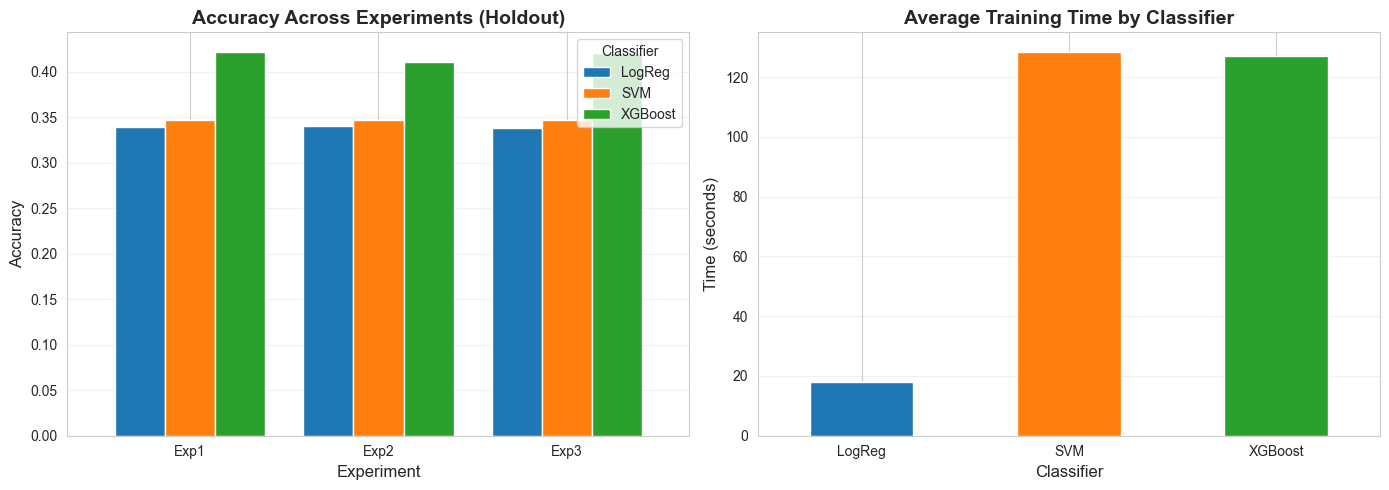


ALL EXPERIMENTS COMPLETE!

Files Generated:
   1. experiment_results_comprehensive.csv
   2. experiment_results_summary.csv
   3. experiment_comparison.png
   4. XGBoost_tuned_best.joblib (or other best model)
   5. scaler_exp5.joblib
   6. label_encoder_exp5.joblib

Ready for report writing and Kaggle submission!


In [38]:
# Export comprehensive results to CSV
results_df = pd.DataFrame(all_experiments)
results_df.to_csv('experiment_results_comprehensive.csv', index=False)
print("Results exported to: experiment_results_comprehensive.csv")

# Create a summary table for the report
summary_for_report = results_df.groupby(['Exp_ID', 'Classifier']).agg({
    'Accuracy': 'first',
    'Precision': 'first',
    'Recall': 'first',
    'F1_Score': 'first',
    'Train_Time': 'first'
}).reset_index()
summary_for_report.to_csv('experiment_results_summary.csv', index=False)
print("Summary table exported to: experiment_results_summary.csv")

# Create visualizations data
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Accuracy comparison across experiments
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy by Experiment and Classifier
holdout_data = results_df[results_df['Exp_ID'].isin(['Exp1', 'Exp2', 'Exp3'])]
pivot_data = holdout_data.pivot(index='Exp_ID', columns='Classifier', values='Accuracy')
pivot_data.plot(kind='bar', ax=ax[0], width=0.8)
ax[0].set_title('Accuracy Across Experiments (Holdout)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Experiment', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)
ax[0].legend(title='Classifier')
ax[0].grid(axis='y', alpha=0.3)

# Plot 2: Training Time Comparison
time_data = holdout_data.groupby('Classifier')['Train_Time'].mean()
time_data.plot(kind='bar', ax=ax[1], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax[1].set_title('Average Training Time by Classifier', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Classifier', fontsize=12)
ax[1].set_ylabel('Time (seconds)', fontsize=12)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)
ax[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('experiment_comparison.png', dpi=300, bbox_inches='tight')
print("Visualization saved to: experiment_comparison.png")
plt.show()

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETE!")
print("="*80)
print("\nFiles Generated:")
print("   1. experiment_results_comprehensive.csv")
print("   2. experiment_results_summary.csv")
print("   3. experiment_comparison.png")
print("   4. XGBoost_tuned_best.joblib (or other best model)")
print("   5. scaler_exp5.joblib")
print("   6. label_encoder_exp5.joblib")
print("\nReady for report writing and Kaggle submission!")